In [1]:
# Install PyTorch with CUDA support (modify according to your system and CUDA version)
!pip install torch torchvision torchaudio

# Install Ray and Ray Tune
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
!ray --version

ray, version 2.44.1


Ray available resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'memory': 9299092276.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3985325260.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
+----------------------------------------------------------+
| Configuration for experiment     mnist_ray_tune          |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 1                       |
+----------------------------------------------------------+

View detailed results here: /root/ray_results/mnist_ray_tune
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-03-30_00-44-06_506243_1037/artifacts/2025-03-30_00-44-09/mnist_ray_tune/driver_artifacts`


  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  1%|          | 65.5k/9.91M [00:00<00:18, 542kB/s]
  3%|▎         | 328k/9.91M [00:00<00:06, 1.49MB/s]
 13%|█▎        | 1.31M/9.91M [00:00<00:01, 4.48MB/s]
 54%|█████▍    | 5.37M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
  0%|          | 0.00/28.9k [00:00<?, ?B/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 470kB/s]
  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  4%|▍         | 65.5k/1.65M [00:00<00:02, 535kB/s]
 16%|█▌        | 262k/1.65M [00:00<00:01, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.3MB/s]
Training:  33%|███▎      | 1/3 [00:09<00:19,  9.94s/epoch, accuracy=0.7667, loss=1.9808]


(train_model pid=10549) Epoch 1/3 - Loss: 1.9808, Accuracy: 0.7667


Training:  67%|██████▋   | 2/3 [00:19<00:09,  9.47s/epoch, accuracy=0.8290, loss=1.2112]


(train_model pid=10549) Epoch 2/3 - Loss: 1.2112, Accuracy: 0.8290

Best config is: {'lr': 0.0014446958752917709, 'batch_size': 32, 'optimizer': 'sgd', 'layer_size': 229, 'dropout_rate': 0.1363585242435261, 'epochs': 3}
Best loss: 0.7980301949183146

Reported metrics for Trial 0:
(train_model pid=10549) Epoch 3/3 - Loss: 0.7980, Accuracy: 0.8579
       loss  accuracy  epoch   timestamp checkpoint_dir_name   done  \
0  1.980834    0.7667      1  1743295468                None  False   
1  1.211188    0.8290      2  1743295477                None  False   
2  0.798030    0.8579      3  1743295487                None   True   

   training_iteration     trial_id                 date  time_this_iter_s  \
0                   1  17a7c_00000  2025-03-30_00-44-28         13.809185   
1                   2  17a7c_00000  2025-03-30_00-44-37          9.136416   
2                   3  17a7c_00000  2025-03-30_00-44-47          9.789673   

   ...      hostname      node_ip time_since_restore itera

Training: 100%|██████████| 3/3 [00:28<00:00,  9.63s/epoch, accuracy=0.8579, loss=0.7980]


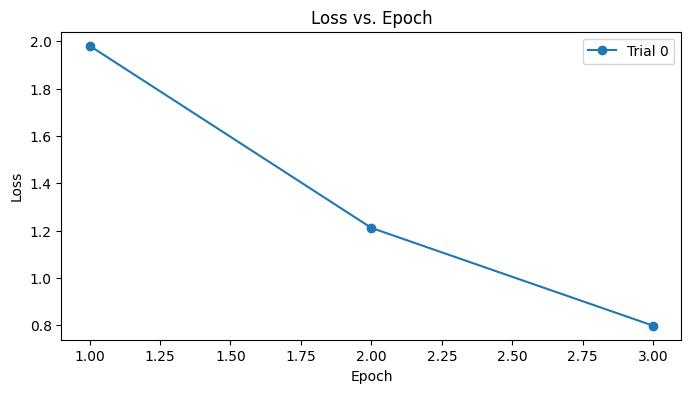

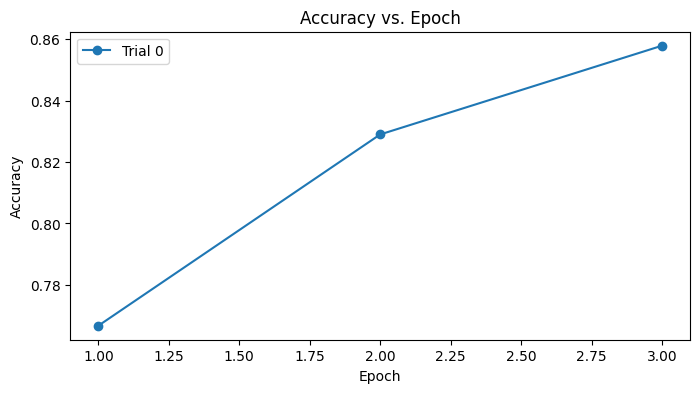

In [12]:
import os
import ray
from ray import tune
from ray.tune import Tuner, TuneConfig
from ray.air import RunConfig
from ray.tune.schedulers import ASHAScheduler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# ---------------------------------------------------------------------------
# Step 1: Define a parameterized model (with **kwargs for extra parameters)
class CustomModel(nn.Module):
    def __init__(self, layer_size=128, dropout_rate=0.3, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.fc1 = nn.Linear(784, layer_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(layer_size, 10)

    def forward(self, x):
        # Flatten the 28x28 MNIST images into a 784-dim vector
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ---------------------------------------------------------------------------
# Step 2: Create the training function with a tqdm progress bar
def train_model(config):
    # Download and prepare the MNIST training dataset
    train_dataset = MNIST(root="data", train=True, transform=ToTensor(), download=True)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    # Download the test dataset for evaluation
    test_dataset = MNIST(root="data", train=False, transform=ToTensor(), download=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # Initialize the model using hyperparameters from config
    model = CustomModel(layer_size=config["layer_size"], dropout_rate=config["dropout_rate"])

    # Dynamically choose the optimizer
    if config["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config["lr"])

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create a tqdm progress bar for the epoch loop
    pbar = tqdm(total=config["epochs"], desc="Training", unit="epoch")

    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # Evaluate the model on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total

        # Update tqdm bar and print metrics
        pbar.set_postfix(loss=f"{avg_loss:.4f}", accuracy=f"{accuracy:.4f}")
        pbar.update(1)
        print(f"Epoch {epoch+1}/{config['epochs']} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Report metrics to Ray Tune
        tune.report({"loss": avg_loss, "accuracy": accuracy, "epoch": epoch+1})

    pbar.close()

# ---------------------------------------------------------------------------
# Step 3: Define the hyperparameter search space
search_space = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    "batch_size": tune.choice([32, 64, 128]),     # Batch size options
    "optimizer": tune.choice(["adam", "sgd"]),    # Optimizer choice
    "layer_size": tune.randint(64, 256),          # Hidden layer size between 64 and 256
    "dropout_rate": tune.uniform(0.1, 0.5),       # Dropout rate between 0.1 and 0.5
    "epochs": 3,                                  # Run 3 epochs for demonstration
}

# ---------------------------------------------------------------------------
# Step 4: Main function to initialize Ray and launch Ray Tune
def main():
    # Shutdown any previous Ray instance and then initialize with 8 CPUs.
    ray.shutdown()
    ray.init(num_cpus=8, ignore_reinit_error=True, logging_level="ERROR", include_dashboard=False)
    print("Ray available resources:", ray.available_resources())

    # Use an ASHA scheduler for early stopping
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=3,
        grace_period=1,
        reduction_factor=2
    )

    # Wrap the training function to allocate all 8 CPUs to a single trial.
    train_with_resources = tune.with_resources(train_model, resources={"cpu": 8})

    # Set up the Tuner with one trial for demonstration.
    tuner = Tuner(
        train_with_resources,
        param_space=search_space,
        tune_config=TuneConfig(
            scheduler=scheduler,
            num_samples=1
        ),
        run_config=RunConfig(
            name="mnist_ray_tune",
            verbose=0  # Minimal Ray Tune output
        )
    )

    results = tuner.fit()
    best_result = results.get_best_result(metric="loss", mode="min")
    print("Best config is:", best_result.config)
    try:
        print("Best loss:", best_result.metrics["loss"])
    except KeyError:
        print("Best loss metric not available.")

    # Print the full story of reported metrics and plot them for each trial
    for i, result in enumerate(results):
        df = result.metrics_dataframe
        print(f"\nReported metrics for Trial {i}:")
        print(df)

        plt.figure(figsize=(8, 4))
        plt.plot(df["epoch"], df["loss"], marker="o", label=f"Trial {i}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs. Epoch")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.plot(df["epoch"], df["accuracy"], marker="o", label=f"Trial {i}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs. Epoch")
        plt.legend()
        plt.show()

    ray.shutdown()

if __name__ == "__main__":
    main()
